# Interactive bar plots
This example demonstrates how to create **interactive bar charts** with **earthkit-plots**, using ensemble precipitation forecasts.

# Example: Precipitation in Bergen
In this example, we fetch ensemble forecasts of precipitation for Bergen, Norway, one of the rainiest cities in Europe.  
The data comes from the **ECMWF IFS model** through [Open-Meteo API](https://open-meteo.com/).

## Fetching the data
We request five days of hourly ensemble precipitation forecasts.  
The requests are cached and retried automatically to ensure reliability.

In [1]:
from datetime import datetime, timedelta

today = datetime.now() + timedelta(days=-3)
tomorrow = today + timedelta(days=5)

today_str = today.strftime("%Y-%m-%d")
tomorrow_str = tomorrow.strftime("%Y-%m-%d")

In [ ]:
import requests_cache
from retry_requests import retry
import openmeteo_requests

cache_session = requests_cache.CachedSession(".cache", expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

ensemble_url = "https://ensemble-api.open-meteo.com/v1/ensemble"
params = {
    "latitude": 60.3913, # Bergen, Norway - rainiest city in Europe
    "longitude": 5.3221,
    "start_date": today_str,
    "end_date": tomorrow_str,
    "hourly": "precipitation",
    "models": "ecmwf_ifs025",
}
ensemble_response = openmeteo.weather_api(ensemble_url, params=params)[0]


## Processing the forecast
Each ensemble member is stored in a separate column of a `pandas.DataFrame`.  
This makes it straightforward to calculate ensemble statistics, such as quantiles and the median.

In [3]:
import pandas as pd

forecast_hourly = ensemble_response.Hourly()

forecast_data = {"date": pd.date_range(
        start=pd.to_datetime(forecast_hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(forecast_hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=forecast_hourly.Interval()),
        inclusive="left"
    ).tz_convert("Europe/Zurich").tz_localize(None)}

for i in range(forecast_hourly.VariablesLength()):
    v = forecast_hourly.Variables(i)
    member = v.EnsembleMember()
    forecast_data[f"precip_member_{member}"] = v.ValuesAsNumpy()

forecast_df = pd.DataFrame(forecast_data)

member_cols = [c for c in forecast_df.columns if "member" in c]

forecast_df_ok = forecast_df[["date"] + member_cols].dropna(subset=member_cols, how="all")


## Calculating quantile bands
To illustrate forecast uncertainty, we calculate:
- the **33rd percentile** (lower quantile),  
- the **66th percentile** (upper quantile), and  
- the **median**.  

The difference between the lower and upper quantiles (`hi - lo`) forms a band that captures the central spread of the ensemble.

In [8]:
import numpy as np

# Quantiles
q_low, q_high = 0.33, 0.66

x = forecast_df_ok["date"].dt.to_pydatetime().tolist()
Y = forecast_df_ok[member_cols].to_numpy(dtype=float)

med = np.nanmedian(Y, axis=1)
lo  = np.nanpercentile(Y, q_low*100,  axis=1)
hi  = np.nanpercentile(Y, q_high*100, axis=1)

/tmp/ipykernel_51671/2894186202.py:6: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



## Plotting the results
We use `earthkit.plots.interactive.bar` to build the chart:
- the **upper quantile** is shown as a patterned bar in blue,  
- the **median** is a solid blue bar,  
- the **lower quantile** is a white patterned bar.  

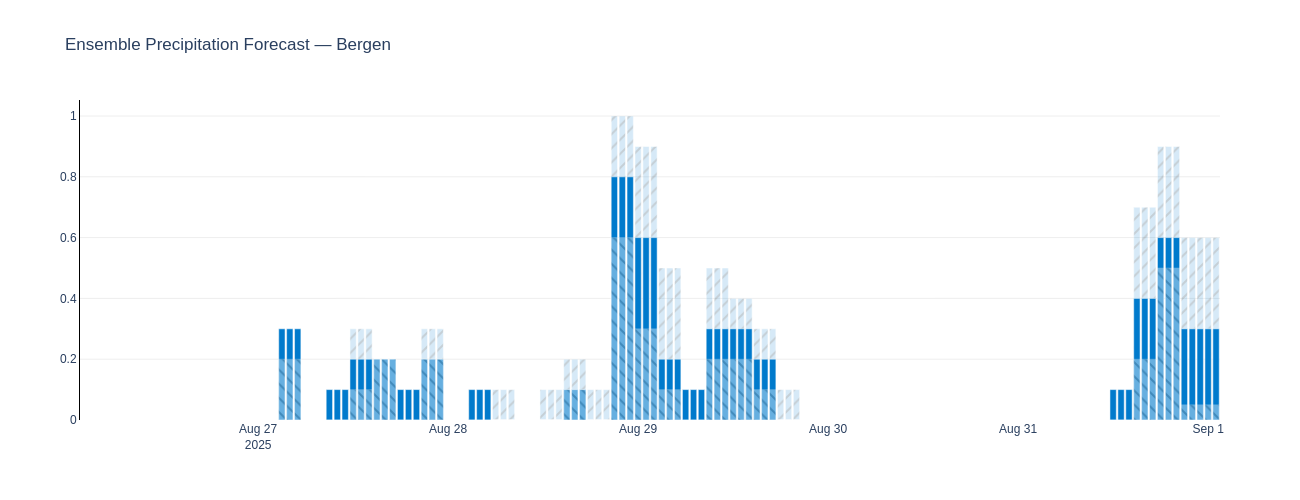

In [9]:

from earthkit.plots.interactive import Chart
from earthkit.plots.interactive import bar as bar_module

chart = Chart()
chart.title("Ensemble Precipitation Forecast — Bergen")

# Upper quantile
for tr in bar_module.bar(
    x=x,
    y=hi,
    name=f"Q{int(q_high*100)}",
    marker=dict(color="rgba(0, 122, 204, 0.4)",
                pattern=dict(shape="/")),
    opacity=0.4,
    showlegend=True,
):
    chart.add_trace(tr)

# Median bar
for tr in bar_module.bar(
    x=x,
    y=med,
    name="Median (bar)",
    marker=dict(color="rgb(0, 122, 204)"),
    showlegend=True,
):
    chart.add_trace(tr)

# Lower quantile
for tr in bar_module.bar(
    x=x,
    y=lo,
    name=f"Q{int(q_low*100)}",
    marker=dict(color="white",
                pattern=dict(shape="\\")),
    opacity=0.4,
    showlegend=True,
):
    chart.add_trace(tr)

# Layout
chart.fig.update_layout(
    barmode="overlay",
    template="plotly_white",
    legend=dict(itemsizing="constant"),
)
chart.show(renderer="png", width=1300, height=500)